In [118]:
#tensorflow/examples/tutorials/mnist/
#from tensorflow.examples.tutorials.mnist import input_data
#data = input_data.read_data_sets("./mnist_data", one_hot=False)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [119]:
def xor(x):
    if x[0] == x[1]:
        return 1
    else:
        return 0
    
def dirty(x):
    noise1 = (np.random.random()*2 - 1)/20
    noise2 = (np.random.random()*2 - 1)/20
    noise = np.array([noise1, noise2])
    return x + noise

In [120]:
data = np.random.randint(0, 2, (1000,2))
x = np.apply_along_axis(dirty, 1, data)
y = np.array(list(map(lambda d: xor(d), data)))
tmp = np.zeros((len(y), 2))
tmp[np.arange(len(y)),y] = 1
y = tmp

In [121]:
input_x = tf.placeholder(tf.float32, [None, 2])
input_y = tf.placeholder(tf.int64, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, 300], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape=[300]))
z1 = tf.nn.xw_plus_b(input_x, w1, b1)
active1 = tf.sigmoid(z1)

w2 = tf.Variable(tf.truncated_normal([300, 2], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=[2]))
z2 = tf.nn.xw_plus_b(active1, w2, b2)

# for test purpose
no_active = tf.nn.xw_plus_b(z1, w2, b2)
sigmoid_active = tf.nn.xw_plus_b(tf.sigmoid(z1), w2, b2)
relu_active = tf.nn.xw_plus_b(tf.nn.relu(z1), w2, b2)

predictions = tf.argmax(z2, axis=1)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y, logits=z2)
mse = tf.reduce_mean(loss)
train = tf.train.GradientDescentOptimizer(0.1).minimize(mse)

In [122]:
bchsize = 256
def generator(train_x, train_y, bchsize=bchsize):
    start = 0
    while True:
        if start > len(train_x):
            start %= bchsize
        batch_x = train_x[start:start+bchsize]
        batch_y = train_y[start:start+bchsize]
        start += bchsize
        yield batch_x, batch_y

In [123]:
# shuffle dataset
random_idx = np.random.choice(len(x), (len(x)), replace=False)
x, y = x[random_idx], y[random_idx]

# split train/test dataset
n_train = int(len(x)*0.8)
train_x, train_y = x[:n_train], y[:n_train]
valid_x, valid_y = x[n_train:], y[n_train:]
valid_y = np.argmax(valid_y, axis=1)

# make generator
gen = generator(train_x, train_y)

In [132]:
steps = 10000

# global variable initialization
init = tf.global_variables_initializer()

train_ops = [loss, mse, train]
transform_ops = [no_active, sigmoid_active, relu_active, predictions]
with tf.Session() as sess:
    # initialization
    sess.run(init)
    
    # do training
    for i in range(steps):
        bx, by = next(gen)
        feed_dict = {
            input_x: bx,
            input_y: by
        }
        train_loss, train_mse, _ = sess.run(train_ops, feed_dict=feed_dict)
        if i % 1000 == 0:
            pred = sess.run(predictions, feed_dict={input_x: valid_x})
            acc = (valid_y == pred).astype(int).mean()
            print('%sth iteration finished: %.4f, validation_accracy: %.4f' % (i, train_mse, acc))
            
    # transform data
    feed_dict = {input_x: x}
    no_active_x, sigmoid_active_x, relu_active_x, pred_x = sess.run(transform_ops, feed_dict=feed_dict)
    
    print(no_active_x.shape, sigmoid_active_x.shape, relu_active_x.shape, pred_x.shape)

0th iteration finished: 0.6880, validation_accracy: 0.5000
1000th iteration finished: 2.1668, validation_accracy: 0.5000
2000th iteration finished: 1.4424, validation_accracy: 0.5000
3000th iteration finished: 1.1521, validation_accracy: 0.5000
4000th iteration finished: 1.0195, validation_accracy: 0.5000
5000th iteration finished: 0.8445, validation_accracy: 0.5000
6000th iteration finished: 0.2315, validation_accracy: 1.0000
7000th iteration finished: 0.0662, validation_accracy: 1.0000
8000th iteration finished: 0.0326, validation_accracy: 1.0000
9000th iteration finished: 0.0203, validation_accracy: 1.0000
(1000, 2) (1000, 2) (1000, 2) (1000,)


In [133]:
y_ = np.argmax(y, axis=1)
(y_ == pred_x).mean()

1.0

In [134]:
import matplotlib.pyplot as plt

zero_idx = np.argmax(y, axis=1) == 0
one_idx = np.argmax(y, axis=1) == 1
zero_x = transformed_x[zero_idx]
one_x = transformed_x[one_idx]

# draw plot
plt.scatter(zero_x[:,0], zero_x[:,1], s=1, c='r')
plt.scatter(one_x[:,0], one_x[:,1], s=1, c='b')

NameError: name 'transformed_x' is not defined

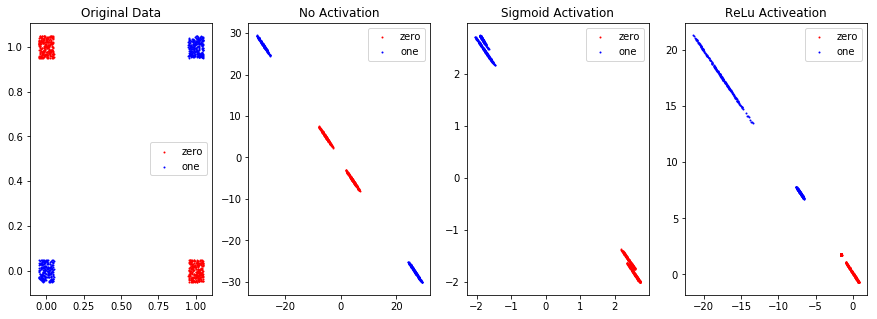

In [135]:
zero_idx = np.argmax(y, axis=1) == 0
one_idx = np.argmax(y, axis=1) == 1

plt.figure(figsize=(15, 5))
plt.subplot(141)
zero_x = x[zero_idx]
one_x = x[one_idx]
plt.scatter(zero_x[:,0], zero_x[:,1], s=1, c='r', label='zero')
plt.scatter(one_x[:,0], one_x[:,1], s=1, c='b', label='one')
plt.legend()
plt.title('Original Data')

plt.subplot(142)
no_active_zero_x = no_active_x[zero_idx]
no_active_one_x = no_active_x[one_idx]
plt.scatter(no_active_zero_x[:,0], no_active_zero_x[:,1], s=1, c='r', label='zero')
plt.scatter(no_active_one_x[:,0], no_active_one_x[:,1], s=1, c='b', label='one')
plt.legend()
plt.title('No Activation')

plt.subplot(143)
sigmoid_active_zero_x = sigmoid_active_x[zero_idx]
sigmoid_active_one_x = sigmoid_active_x[one_idx]
plt.scatter(sigmoid_active_zero_x[:,0], sigmoid_active_zero_x[:,1], s=1, c='r', label='zero')
plt.scatter(sigmoid_active_one_x[:,0], sigmoid_active_one_x[:,1], s=1, c='b', label='one')
plt.legend()
plt.title('Sigmoid Activation')

plt.subplot(144)
relu_active_zero_x = relu_active_x[zero_idx]
relu_active_one_x = relu_active_x[one_idx]
plt.scatter(relu_active_zero_x[:,0], relu_active_zero_x[:,1], s=1, c='r', label='zero')
plt.scatter(relu_active_one_x[:,0], relu_active_one_x[:,1], s=1, c='b', label='one')
plt.title('ReLu Activeation')
plt.legend()

# save png
plt.savefig('active_plot.png')

# draw sigmoid, softmax, tahn

In [109]:
def sigmoid(x):
    return 1/(1+np.e**-x)

def tanh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def relu(x):
    return max(x, 0)

In [110]:
x = np.arange(-200, 200)/20
sigmoid_y = list(map(sigmoid, x))
tanh_y = list(map(tanh, x))
relu_y = list(map(relu, x))

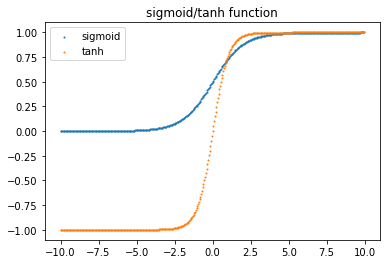

In [115]:
plt.scatter(x, sigmoid_y, s=1, label='sigmoid')
plt.scatter(x, tanh_y, s=1, label='tanh')
plt.legend()
plt.title('sigmoid/tanh function')
plt.savefig('sigtan.png')

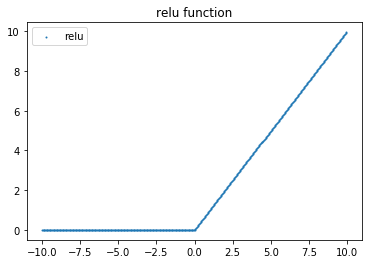

In [116]:
plt.scatter(x, relu_y, s=1, label='relu')
plt.legend()
plt.title('relu function')
plt.savefig('relu.png')